In [ ]:
"""
Post-processing analysis script for cortical layer intensity data.
This code processes and visualizes results from quality_control_native_surface_slurm.py

#use conda env: niwrap3912
"""
import os
import yaspy
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import zscore
# Define paths
data_base_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_120um_max_480um_dist_method0"
#postfix
postfix = data_base_path.split('_')[-1]
base_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"
subject_name = "I45_new_confidence"
hemisphere = "lh"
layer = 'inf'
data_type = 'diff'
use_normalized_data = True

# Construct file paths
intensity_file = f"{data_base_path}/{subject_name}/{hemisphere}/intensity_{data_type}_{postfix}_results.npz"
print(intensity_file)
surface_file = f"{base_path}/{subject_name}/{hemisphere}.{layer}.32k_fs_LR.surf.gii"


cmap = 'RdBu_r'
# Initialize surface plotter
plotter = yaspy.Plotter(surface_file, hemi=hemisphere)
# Load intensity data
data = np.load(intensity_file, allow_pickle=True)
params = data['params']
dist_array = params.item()['dist_array']

if data_type == 'diff':
    #at 0.06 is where the zero should be* I checked with local file
    at_zero = np.where(dist_array == 0.06)[0][0]#this is where the zero should be at for diff dtta
else:
    at_zero = np.where(dist_array == 0.06)[0][0]# 

print('zero value at:',at_zero)
ap_order = data['inf_ap_order']
# Sort data by anterior-posterior order
surface_order = np.argsort(ap_order)
if use_normalized_data:
    data2plot = data[f'{layer}_{data_type}_norm_intensity'][at_zero, surface_order]
else:
    data2plot = data[f'{layer}_{data_type}_intensity'][at_zero, surface_order]
#vmin, vmax = np.percentile(data2plot, [2, 98])
vmin = -1
vmax = 1
#m = np.maximum(np.abs(vmin), np.abs(vmax))

# Create colormap normalization and ScalarMappable
norm = Normalize(vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
# Calculate intensity range for visualization


# Create surface overlay
overlay = plotter.overlay(
    data2plot, 
    cmap=cmap,
    vmin=vmin,    
    vmax=vmax
)

# Generate multi-view montage
views = ['lateral', 'medial']
screenshots = [plotter.screenshot(view) for view in views]
montage = yaspy.montage(screenshots, pad=8)


# Create and style figure
fig, ax = plt.subplots(figsize=(6,4))
for spine in ax.spines.values():
    spine.set_visible(False)
plt.imshow(montage,cmap='viridis')
plt.axis('off')


cax = ax.inset_axes((0.8, 0, 0.18, 0.04))
cbar = plt.colorbar(overlay, cax=cax, orientation="horizontal", extend='both')
cbar.mappable.set_clim(vmin, vmax)
cbar.ax.tick_params(labelsize="x-small")
plt.title("Intensity Difference (+/- 60um white matter surface)", fontsize="medium")


/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_120um_max_480um_dist_method0/I45_new_confidence/lh/intensity_diff_method0_results.npz


FileNotFoundError: [Errno 2] No such file or directory: '/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_120um_max_480um_dist_method0/I45_new_confidence/lh/intensity_diff_method0_results.npz'

In [ ]:
''' THIS IS FOR MYELO ARCHITECTURE PARCELLATION*** 090225 -DJ
#I mean the paper says that the granular layer is included in the infragranular layer (Zeng et al., 2024; 7T ex vivo data segmentation...)
#this sections can only be run after "run_myelo_parcellation.ipynb"

#A whole-brain 3D myeloarchitectonic atlas: Mapping the Vogt-Vogt legacy to the cortical surface
import os
import nibabel as nib

#fsaverage  ico6 *
base_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"
#subject_name = "I45_new_confidence"
niu_folder = "niu_parcellation_output"
hemisphere = "lh"
layer = "inf"
#for nieuwenhuys
#file_name = f"{subject_name}_{hemisphere}_nieuwenhuys_parcellation.label.gii"
#for Baillarger
parcel_type = "nieuwenhuys" #or "baillarger"
if parcel_type.lower() == "nieuwenhuys":
    file_name = f"{subject_name}_{hemisphere}_nieuwenhuys_parcellation.label.gii"
    title_name = "Nieuwenhuys parcellation"
elif parcel_type.lower() == "baillarger":   
    file_name = f"{subject_name}_{hemisphere}_baillarger_parcellation.label.gii"
    title_name = "Baillarger parcellation"
#surface file to plot this
surface_file = surface_file = f"{base_path}/{subject_name}/{hemisphere}.{layer}.32k_fs_LR.surf.gii"
#read the file     

# Read the annotation file
niu_file = nib.load(os.path.join(base_path, subject_name, niu_folder, file_name))
label_data = niu_file.darrays[0].data
label_color = niu_file.labeltable
# Extract just the color values from the labels
color_values = [label.rgba for label in label_color.labels]
from matplotlib.colors import ListedColormap
orig_cmap = ListedColormap(color_values)
orig_cmap = 'jet'
#so the size is 164k and I need to dwonsample to 32k
plotter = yaspy.Plotter(surface_file, hemi=hemisphere)
plotter.overlay(label_data, cmap=orig_cmap)

#make colormap using the colorvales


# Generate multi-view montage
views = ['lateral', 'medial']
screenshots = [plotter.screenshot(view) for view in views]
montage = yaspy.montage(screenshots, pad=8)
# Create and style figure
fig, ax = plt.subplots(figsize=(6,4))
for spine in ax.spines.values():
    spine.set_visible(False)
plt.imshow(montage,cmap=orig_cmap)
plt.axis('off')


norm = plt.Normalize(vmin=np.min(label_data), vmax=np.max(label_data))
sm = plt.cm.ScalarMappable(cmap=orig_cmap, norm=norm)
cax = ax.inset_axes((0.8, 0, 0.18, 0.04))
cbar = plt.colorbar(sm, cax=cax, orientation="horizontal", extend='both')
cbar.ax.tick_params(labelsize="x-small")
plt.title(f"{title_name}, subject: {subject_name}", fontsize="medium")
'''

' THIS IS FOR MYELO ARCHITECTURE PARCELLATION*** 090225 -DJ\n#I mean the paper says that the granular layer is included in the infragranular layer (Zeng et al., 2024; 7T ex vivo data segmentation...)\n#this sections can only be run after "run_myelo_parcellation.ipynb"\n\n#A whole-brain 3D myeloarchitectonic atlas: Mapping the Vogt-Vogt legacy to the cortical surface\nimport os\nimport nibabel as nib\n\n#fsaverage  ico6 *\nbase_path = "/Users/dennis.jungchildmind.org/Desktop/exvivo"\n#subject_name = "I45_new_confidence"\nniu_folder = "niu_parcellation_output"\nhemisphere = "lh"\nlayer = "inf"\n#for nieuwenhuys\n#file_name = f"{subject_name}_{hemisphere}_nieuwenhuys_parcellation.label.gii"\n#for Baillarger\nparcel_type = "nieuwenhuys" #or "baillarger"\nif parcel_type.lower() == "nieuwenhuys":\n    file_name = f"{subject_name}_{hemisphere}_nieuwenhuys_parcellation.label.gii"\n    title_name = "Nieuwenhuys parcellation"\nelif parcel_type.lower() == "baillarger":   \n    file_name = f"{subj

In [ ]:
#do analysis separate for lh and rh
lh_intensity_data_uncut = [];
rh_intensity_data_uncut = [];
lh_label_data = [];
rh_label_data = [];
lh_subject_names = [];
rh_subject_names = [];
layer = 'inf'
data_type = "diff"
use_normalized_data = True

base_path_intensity = "/Users/dennis.jungchildmind.org/Desktop/exvivo_figures_norm_120um"
#postfix
postfix = data_base_path.split('_')[-1]#this grabs 120um

for subjects in os.listdir(base_path):
    #for now skip I54_confidence
    if subjects == 'I54_new_confidence':
        continue
    if subjects:
        for hemispheres in ['lh','rh']:
            intensity_file_path = os.path.join(base_path_intensity, subjects, f"{hemispheres}/intensity_{data_type}_{postfix}_results.npz")

            if os.path.exists(intensity_file_path):
                # Load intensity data
                data = np.load(intensity_file_path, allow_pickle=True)
                params = data['params']
                dist_array = params.item()['dist_array']

                if data_type == 'diff':
                    #at 0.06 is where the zero should be* I checked with local file
                    at_zero = np.where(dist_array == 0.06)[0][0]#this is where the zero should be at for diff dtta
                else:
                    at_zero = np.where(dist_array == 0.06)[0][0]# 

                print('zero value at:',at_zero)
                #
                #ap_order = data['inf_ap_order']
                ## Sort data by anterior-posterior order
                #surface_order = np.argsort(ap_order)

                if use_normalized_data:
                    tmp_dat = data[f'{layer}_{data_type}_norm_intensity'];
                else:
                    tmp_dat = data[f'{layer}_{data_type}_intensity'];
                num_rows = 8#put ood number here i think?
                tick_vals = num_rows*0.12
    
                
                if hemispheres == 'lh':
                    lh_intensity_data_uncut.append(tmp_dat)
                    lh_subject_names.append(subjects.replace('_new_confidence',''))
                else:
                    rh_intensity_data_uncut.append(tmp_dat)
                    rh_subject_names.append(subjects.replace('_new_confidence',''))



In [81]:
spacing_mm = 0.12
plt.figure(figsize=(8,4))

# Set up y-ticks
y_max = tmp_dat.shape[0]
y_tick_indices = np.arange(0, y_max, 3)  # Every 3rd index

# Plot both hemispheres
for subplot_idx, (hemi, subject_names, subject_data) in enumerate([
    ('lh', lh_subject_names, lh_intensity_data_uncut),
    ('rh', rh_subject_names, rh_intensity_data_uncut)
], 1):
    
    plt.subplot(1, 2, subplot_idx)
    plt.yticks(y_tick_indices+2)
    plt.gca().set_yticklabels(np.round((y_tick_indices-15)*spacing_mm,2))
    
    # Plot each subject
    for i, tmp in enumerate(subject_data):
        mean_intensity = np.mean(tmp, axis=1)
        sem_intensity = np.std(tmp, axis=1) / np.sqrt(tmp.shape[1])
        
        plt.errorbar(mean_intensity[::-1], np.arange(len(mean_intensity)), 
                    xerr=sem_intensity[::-1], fmt='-o', linewidth=1, 
                    markersize=3, alpha=0.5, label=subject_names[i])
    
    # 
    mid_line = np.ceil(len(subject_data[0])/2)
    plt.ylim(mid_line-6,mid_line+6)
    plt.xlim(-2,2)
    # Add reference lines
    plt.axhline(y=mid_line, color='black', linestyle='--')
    plt.axvline(x=0, color='black', linestyle='--')
    plt.xlabel('Mean Intensity Difference')
    plt.ylabel('Distance from Inf Surface (mm)')
    plt.title(f'{hemi.upper()[0] + hemi[1:].upper()}')
    plt.legend()

plt.tight_layout()
plt.show()


NameError: name 'lh_intensity_data_uncut' is not defined

<Figure size 800x400 with 0 Axes>

In [83]:
print(dist_array)

[ 0.48  0.24  0.   -0.24 -0.48]


240um
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
1
(4, 32492)
[ 0.48  0.24  0.   -0.24 -0.48]


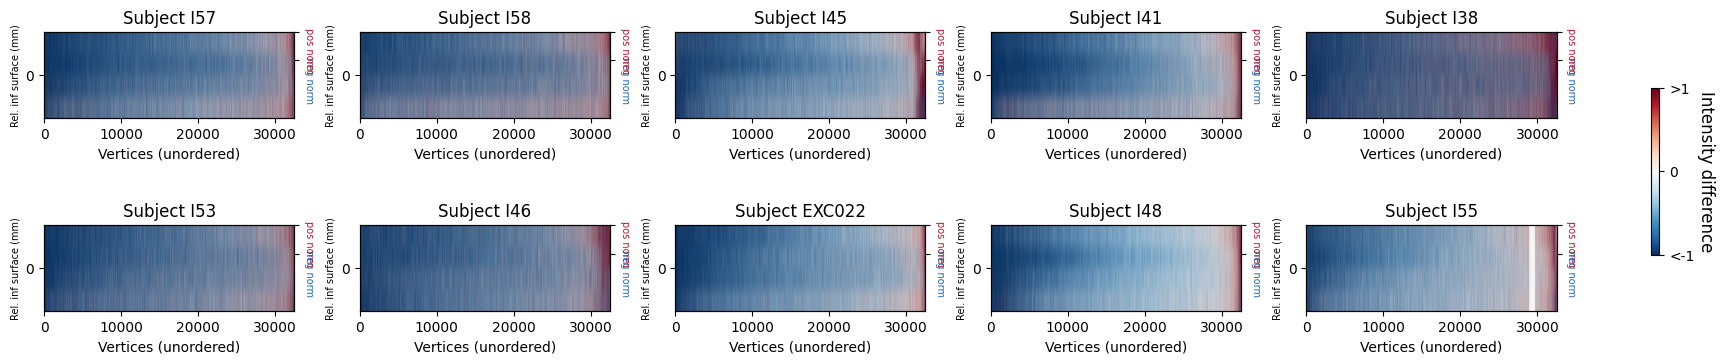

In [86]:
from scipy.stats import zscore

#do analysis separate for lh and rh
lh_intensity_data = [];
rh_intensity_data = [];
lh_label_data = [];
rh_label_data = [];
lh_subject_names = [];
rh_subject_names = [];
layer = 'inf'
data_type = "diff"
use_normalized_data =False
do_diff = True
clim_max = 1
spacing_mm = 0.24#make it the same as the data
base_path_intensity = "/Users/dennis.jungchildmind.org/Desktop/exvivo_postslurm/output_240um_max_480um_dist_method1"
postfix = base_path_intensity.split('_')[-5]

print(postfix)
for subjects in os.listdir(base_path):
    #for now skip I54_confidence
    if subjects == 'I54_new_confidence':
        continue
    if subjects:
        for hemispheres in ['lh','rh']:
            intensity_file_path = os.path.join(base_path_intensity, subjects, f"{hemispheres}/intensity_{data_type}_{postfix}_results.npz")

            if os.path.exists(intensity_file_path):
                # Load intensity data
                data = np.load(intensity_file_path, allow_pickle=True)
                params = data['params']
                dist_array = params.item()['dist_array']
                min_dist = np.min(dist_array)
                max_dist = np.max(dist_array)
                '''
                if data_type == 'diff':
                    #at 0.06 is where the zero should be* I checked with local file
                    at_zero = np.where(dist_array == 0.06)[0][0]#this is where the zero should be at for diff dtta
                else:
                    at_zero = np.where(dist_array == 0.06)[0][0]# 
                '''
                #grab the last postivie value before negative
                #the first index is removed from getting the zero because we are calculating differences
                if data_type == 'diff':
                    zero_indices = np.where(dist_array[1:] == 0)[0]
                else:
                #for non-distance, this should be correct
                    zero_indices = np.where(dist_array == 0)[0]

                if len(zero_indices) > 0:
                    at_zero = zero_indices[0]
                else:
                    at_zero = np.where(dist_array > 0)[0][-1]
                print(at_zero)
                #
                #ap_order = data['inf_ap_order']
                ## Sort data by anterior-posterior order
                #surface_order = np.argsort(ap_order)
                
                

                if use_normalized_data:
                    tmp_dat = data[f'{layer}_{data_type}_norm_intensity'];
                else:   
                    tmp_dat = data[f'{layer}_{data_type}_intensity'];
   
            
                #sort by column intensity
                #intensity_tmp_data = tmp_dat[:, np.argsort(tmp_dat[at_zero,:])]
                 #intensity_tmp_data = intensity_tmp_data[at_zero-num_rows:at_zero+num_rows+1, :]
               

                print(tmp_dat.shape)
                #order data by mean intensity along column
                intensity_tmp_data = tmp_dat[:,np.argsort(np.mean(tmp_dat,axis=0))]
                #intensity_tmp_data = intensity_tmp_data[at_zero-num_rows:at_zero+num_rows+1, :]
              
                
                if hemispheres == 'lh':
                    lh_intensity_data.append(intensity_tmp_data)
                    lh_subject_names.append(subjects.replace('_new_confidence',''))
                else:
                    rh_intensity_data.append(intensity_tmp_data)
                    rh_subject_names.append(subjects.replace('_new_confidence',''))

rh_intensity_data = np.array(rh_intensity_data) 
lh_intensity_data = np.array(lh_intensity_data)
rh_label_data = np.array(rh_label_data)
lh_label_data = np.array(lh_label_data)

## plot start

x_label_title = 'Vertices (unordered)'
layer_type = 'inf'

y_extent = [min_dist,max_dist]
cmap = 'RdBu_r'

# Create figure with subplots
hemi = 'lh'
data = rh_intensity_data if hemi == 'rh' else lh_intensity_data
subject_names = rh_subject_names if hemi == 'rh' else lh_subject_names
n_subjects = len(data)

cols = min(5, n_subjects)  # Max 5 columns
rows = (n_subjects + cols - 1) // cols  # Calculate required rows

fig, axes = plt.subplots(rows, cols, figsize=(cols*4, rows*2))
if n_subjects == 1:
    axes = [axes]
elif rows == 1:
    axes = axes.reshape(1, -1)

# Flatten axes for easier indexing
axes_flat = axes.flatten()

# Keep track of the last image for colorbar
im = None

for idx, le_data in enumerate(data):
    ax = axes_flat[idx]
  #  le_data = zscore(le_data,axis=0)
    im = ax.imshow(le_data, aspect='auto', cmap=cmap, 
                  extent=[0, le_data.shape[1], y_extent[0], y_extent[1]])
    
    # Configure clim
    im.set_clim(-clim_max, clim_max)
    
    # Configure axes
    y_ticks_pos = np.arange(0, y_extent[1], spacing_mm*2)
    y_ticks_neg = np.arange(0, y_extent[0], -spacing_mm*2)[1:]
    y_ticks = np.concatenate([y_ticks_neg, y_ticks_pos])
    
    ax.set_yticks(y_ticks)
    ax.set_ylabel(f'Rel. {layer_type} surface (mm)',fontsize = 7)
    ax.set_xlabel(x_label_title)
    ax.set_ylim(min_dist,max_dist)
   # ax.set_ylim(-num_rows*spacing_mm ,num_rows*spacing_mm)
   # ax.axhline(y=0, color='black', linewidth=0.5, linestyle=':')
    
    # Add subject title
    ax.set_title(f'Subject {subject_names[idx]}')

    # Add direction labels
    ax2 = ax.twinx()
    ax2.set_ylim(y_extent)
    ax2.set_yticks([spacing_mm*10, spacing_mm*len(le_data)*4])
    ax2.set_yticklabels(['neg norm', 'pos norm'], rotation=-90, fontsize=7)
    ax2.get_yticklabels()[0].set_color('#2166AC')
    ax2.get_yticklabels()[1].set_color('#B2182B')


# Hide unused subplots
for idx in range(n_subjects, len(axes_flat)):
    axes_flat[idx].set_visible(False)

plt.tight_layout(pad=2.0, h_pad=3.0, w_pad=2.0)

# Add a single colorbar for all subplots after tight_layout
cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.6, aspect=20)
if do_diff:
    if use_normalized_data:
        cbar.set_label('Intensity difference (z-score)', fontsize=12, rotation=270, labelpad=15)
    else:
        cbar.set_label('Intensity difference', fontsize=12, rotation=270, labelpad=15)
else:
    if use_normalized_data:
        cbar.set_label('Intensity (z-score)', fontsize=12, rotation=270, labelpad=15)
    else:
        cbar.set_label('Intensity', fontsize=12, rotation=270, labelpad=15)

cbar.set_ticks([-clim_max, 0, clim_max])
cbar.ax.set_yticklabels([f'<-{clim_max}', '0', f'>{clim_max}'])
print(dist_array)


In [73]:
print(intensity_tmp_data.shape)

(7, 32492)


In [ ]:
zero_indices = np.where(dist_array[1:] == 0)[0]
if len(zero_indices) > 0:
    print(zero_indices[0])
else:
    print(np.where(dist_array > 0)[0][-1])


9


In [ ]:
print(dist_array.shape)
print(tmp_dat.shape)

(21,)
(20, 32492)


In [ ]:
 1.08  0.96  0.84  0.72  0.6   0.48  0.36  0.24  0.12  0.   -0.12
 -0.24 -0.36 -0.48 -0.6  -0.72 -0.84 -0.96 -1.08 -1.2 

[ 1.02  0.9   0.78  0.66  0.54  0.42  0.3   0.18  0.06 -0.06 -0.18
 -0.3  -0.42 -0.54 -0.66 -0.78 -0.9  -1.02 -1.14]

In [ ]:
#do analysis separate for lh and rh
lh_intensity_data_at_zero = [];
rh_intensity_data_at_zero = [];
lh_intensity_data_at_plus_036 = []# 3 ticks since the spacing is 0.12mm
rh_intensity_data_at_plus_036 = []
lh_intensity_data_at_minus_036 = []
rh_intensity_data_at_minus_036 = []
lh_label_data = [];
rh_label_data = [];
lh_subject_names = [];
rh_subject_names = [];
layer = 'white'
data_type = "diff"

parcel_type = "baillarger" #or "baillarger"
base_path_intensity = "/Users/dennis.jungchildmind.org/Desktop/exvivo_figures_norm_120um"
for subjects in os.listdir(base_path):
    #for now skip I54_confidence
    if subjects == 'I54_new_confidence':
        continue
    if subjects:
        for hemispheres in ['lh','rh']:
            label_file_path = os.path.join(base_path, subjects, niu_folder, f"{subjects}_{hemispheres}_{parcel_type}_parcellation.label.gii")
            intensity_file_path = os.path.join(base_path_intensity, subjects, f"{hemispheres}/intensity_norm_{data_type}_results.npz")

            if os.path.exists(label_file_path):
                print(label_file_path)
                label_tmp = nib.load(label_file_path).darrays[0].data
                print(label_tmp)
                # Load intensity data
                data = np.load(intensity_file_path, allow_pickle=True)
                params = data['params']
                dist_array = params.item()['dist_array']

                if data_type == 'diff':
                    #at 0.06 is where the zero should be* I checked with local file
                    at_zero = np.where(dist_array == 0.06)[0][0]#this is where the zero should be at for diff dtta
                else:
                    at_zero = np.where(dist_array == 0.06)[0][0]# 

                print('zero value at:',at_zero)
                ap_order = data['inf_ap_order']
                # Sort data by anterior-posterior order
                surface_order = np.argsort(ap_order)

                #difference away
                num_ticks_away_from_surface = 1
                intensity_tmp_data = data[f'{layer}_{data_type}_intensity'][at_zero, surface_order]
                intensity_tmp_data_at_plus_036 = data[f'{layer}_{data_type}_intensity'][at_zero+num_ticks_away_from_surface, surface_order]
                intensity_tmp_data_at_minus_036 = data[f'{layer}_{data_type}_intensity'][at_zero-num_ticks_away_from_surface, surface_order]

                
                if hemispheres == 'lh':
                    lh_label_data.append(label_tmp)
                    lh_intensity_data_at_zero.append(intensity_tmp_data)
                    lh_intensity_data_at_plus_036.append(intensity_tmp_data_at_plus_036)
                    lh_intensity_data_at_minus_036.append(intensity_tmp_data_at_minus_036)
                    lh_subject_names.append(subjects.replace('_new_confidence',''))
                else:
                    rh_label_data.append(label_tmp)
                    rh_intensity_data_at_zero.append(intensity_tmp_data)
                    rh_intensity_data_at_plus_036.append(intensity_tmp_data_at_plus_036)
                    rh_intensity_data_at_minus_036.append(intensity_tmp_data_at_minus_036)
                    rh_subject_names.append(subjects.replace('_new_confidence',''))

rh_intensity_data_at_zero = np.array(rh_intensity_data_at_zero) 
lh_intensity_data_at_zero = np.array(lh_intensity_data_at_zero)
rh_intensity_data_at_plus_036 = np.array(rh_intensity_data_at_plus_036)
lh_intensity_data_at_plus_036 = np.array(lh_intensity_data_at_plus_036)
rh_intensity_data_at_minus_036 = np.array(rh_intensity_data_at_minus_036)
lh_intensity_data_at_minus_036 = np.array(lh_intensity_data_at_minus_036)
rh_label_data = np.array(rh_label_data)
lh_label_data = np.array(lh_label_data)

NameError: name 'niu_folder' is not defined

IndexError: list index out of range

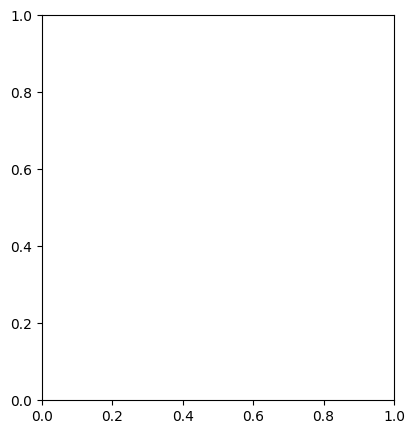

In [ ]:
from scipy.stats import gaussian_kde
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)

index = 0
kde = gaussian_kde(lh_intensity_data_at_zero[index])
x_range = np.linspace(-10,10, 500)
plt.plot(x_range, kde(x_range), alpha=0.5, linewidth=0.5, marker='s', label='at inf surface')
kde_plus_036 = gaussian_kde(lh_intensity_data_at_plus_036[index])
x_range = np.linspace(-10,10, 500)
plt.plot(x_range, kde_plus_036(x_range), alpha=0.5, linewidth=1, marker='o', label='at -0.36mm') #pluse036 is negative **
kde_minus_036 = gaussian_kde(lh_intensity_data_at_minus_036[index])
x_range = np.linspace(-10,10, 500)
plt.plot(x_range, kde_minus_036(x_range), alpha=0.5, linewidth=1, marker='^', label='at 0.36mm')
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference ')
plt.ylabel('Density')
subject_name = lh_subject_names[0]
plt.title(subject_name)

In [ ]:
#okay now do for every subjects in lh
hemi = 'rh'

if hemi == 'lh':
    num_subjects = len(lh_intensity_data_at_zero)
elif hemi == 'rh':
    num_subjects = len(rh_intensity_data_at_zero)
cols = 5
rows = (num_subjects + cols - 1) // cols  # Calculate rows needed

plt.figure(figsize=(15, 3 * rows))

for i in range(num_subjects):
    plt.subplot(rows, cols, i + 1)
    if hemi == 'lh':
        kde = gaussian_kde(lh_intensity_data_at_zero[i])
    elif hemi == 'rh':
        kde = gaussian_kde(rh_intensity_data_at_zero[i])

    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde(x_range), alpha=0.5, linewidth=0.5, marker='s', label='at inf surface')
    kde_plus_036 = gaussian_kde(lh_intensity_data_at_plus_036[i])
    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde_plus_036(x_range), alpha=0.5, linewidth=1, marker='o', label='at -0.36mm') #pluse036 is negative **
    kde_minus_036 = gaussian_kde(lh_intensity_data_at_minus_036[i])
    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde_minus_036(x_range), alpha=0.5, linewidth=1, marker='^', label='at 0.36mm')
    if i == 0:  # Only show legend for the first plot
        plt.legend()
    plt.xlim(-5,5)
    plt.xlabel('Intensity difference ')
    plt.ylabel('Density')
    if hemi == 'lh':
        subject_name = lh_subject_names[i]
    elif hemi == 'rh':
        subject_name = rh_subject_names[i]
    plt.title(subject_name)

plt.tight_layout()


NameError: name 'rh_intensity_data_at_zero' is not defined

Text(0, 0.5, 'Density')

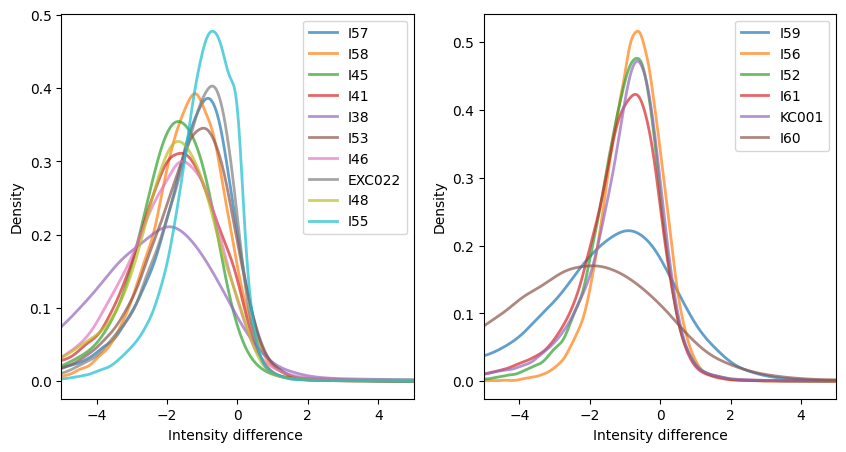

In [ ]:
from scipy.stats import gaussian_kde
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i,tmp in enumerate(lh_intensity_data_at_zero):
    kde = gaussian_kde(tmp)
    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde(x_range), alpha=0.7, linewidth=2, label=lh_subject_names[i])
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference ')
plt.ylabel('Density')

plt.subplot(1,2,2)
for i,tmp in enumerate(rh_intensity_data_at_zero):
    kde = gaussian_kde(tmp)
    x_range = np.linspace(-10,10, 500)
    plt.plot(x_range, kde(x_range), alpha=0.7, linewidth=2, label=rh_subject_names[i])
    
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference')
plt.ylabel('Density')


NameError: name 'lh_intensity_data' is not defined

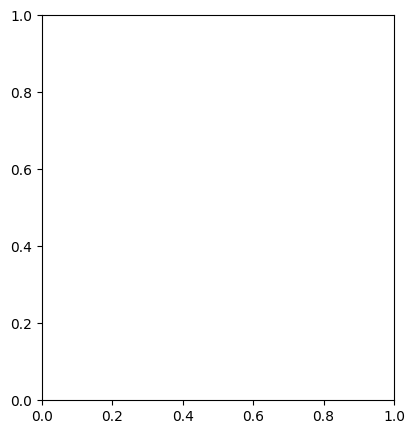

In [ ]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i,tmp in enumerate(lh_intensity_data):
    plt.hist(tmp, bins=500, alpha=0.3, label=lh_subject_names[i], density=True)
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference')
plt.ylabel('Density')

plt.subplot(1,2,2)
for i,tmp in enumerate(rh_intensity_data):
    plt.hist(tmp, bins=500, alpha=0.3, label=rh_subject_names[i], density=True)
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference')
plt.ylabel('Density')


from scipy.stats import gaussian_kde
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
for i,tmp in enumerate(lh_intensity_data):
    kde = gaussian_kde(tmp)
    x_range = np.linspace(-5, 5, 500)
    plt.plot(x_range, kde(x_range), alpha=0.7, linewidth=2, label=lh_subject_names[i])
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference ')
plt.ylabel('Density')

plt.subplot(1,2,2)
for i,tmp in enumerate(rh_intensity_data):
    kde = gaussian_kde(tmp)
    x_range = np.linspace(-5, 5, 500)
    plt.plot(x_range, kde(x_range), alpha=0.7, linewidth=2, label=rh_subject_names[i])
plt.legend()
plt.xlim(-5,5)
plt.xlabel('Intensity difference')
plt.ylabel('Density')


In [43]:
spacing_mm = 0.24
dist_max_mm = 0.48  
tmp = np.flipud(np.concatenate([-np.arange(spacing_mm, dist_max_mm + spacing_mm, spacing_mm)[::-1], [0], 
                                            np.arange(spacing_mm, dist_max_mm + spacing_mm, spacing_mm)]))
print(tmp)

[ 0.48  0.24  0.   -0.24 -0.48]


NameError: name 'lh_intensity_data' is not defined

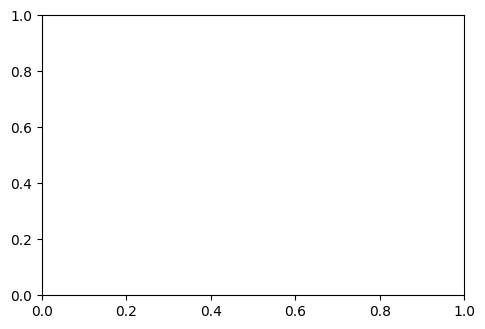

In [ ]:
#resulting in 214 regions (64 frontal, 60 parietal, 63 temporal, 21 occipital, and 6 insular)
#find the
clim_rng = [-1,1]
plt.figure(figsize=(12,8))
plt.subplot(2,2,1)
plt.imshow(lh_intensity_data, aspect='auto',cmap='RdBu_r')
plt.colorbar() 
plt.clim(clim_rng)
plt.ylabel('Subject')
plt.xlabel('Vertices (unordered)')
#plt.yticks(range(len(lh_intensity_data)), range(1, len(lh_intensity_data) + 1))
#set yticks to be subject names 
plt.yticks(range(len(lh_intensity_data)), lh_subject_names)

plt.subplot(2,2,2)
plt.imshow(rh_intensity_data, aspect='auto',cmap='RdBu_r')
plt.colorbar() 
plt.clim(clim_rng)
plt.ylabel('Subject')
plt.xlabel('Vertices (unordered)')
#plt.yticks(range(len(rh_intensity_data)), range(1, len(rh_intensity_data) + 1))
#set yticks to be subject names 
plt.yticks(range(len(rh_intensity_data)), rh_subject_names)
sorting_index = np.argsort(rh_label_data[0,:])
find_bndries = np.where(np.diff(rh_label_data[0,sorting_index]) != 0)[0]

plt.subplot(2,2,3)  
plt.imshow(lh_intensity_data[:,sorting_index], aspect='auto',cmap='RdBu_r')
plt.colorbar() 
plt.clim(clim_rng)
plt.ylabel('Subject')
plt.xlabel('Vertices (ordered based on Baillarger type)')
#plt.yticks(range(len(lh_intensity_data)), range(1, len(lh_intensity_data) + 1))
#set yticks to be subject names
plt.yticks(range(len(lh_intensity_data)), lh_subject_names)
#draw vertical liens
for i in find_bndries:
    plt.axvline(i, color='k', linestyle='--')

sorting_index = np.argsort(lh_label_data[0,:])
find_bndries = np.where(np.diff(lh_label_data[0,sorting_index]) != 0)[0]
plt.subplot(2,2,4)
plt.imshow(rh_intensity_data[:,sorting_index], aspect='auto',cmap='RdBu_r')
plt.colorbar() 
plt.clim(clim_rng)
plt.ylabel('Subject')
#set yticks to be subject names
plt.yticks(range(len(rh_intensity_data)), rh_subject_names)
plt.xlabel('Vertices (ordered based on Baillarger type)')
#plt.yticks(range(len(rh_intensity_data)), range(1, len(rh_intensity_data) + 1))
#draw vertical liens
vert_line_names = ['']
for i in find_bndries:
    plt.axvline(i, color='k', linestyle='--')
    #for 


In [ ]:
#load von